In [1]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LeakyReLU



import sympy
import pandas as pd
import xgboost
import shap
np.random.seed(1)
from problem_creator import gen_regression_symbolic, gen_classification_symbolic
import warnings
shap.initjs()
from collections import defaultdict
#warnings.filterwarnings("default", category=DeprecationWarning,module=user_ns.get("__name__"))

Using TensorFlow backend.


In [2]:
def test_data():
    x1 = np.random.uniform(-20,21,5000)
    x2 = np.random.uniform(-20,21,5000)
    x2 = np.sort(x2)
    x3 = np.zeros(5000)
    x3[:1000] = np.random.uniform(-20,-10,1000)
    x3[1000:2000] = np.random.uniform(-15,0,1000)
    x3[2000:3000] = np.random.uniform(-5,10,1000)
    x3[3000:4000] = np.random.uniform(5,15,1000)
    x3[4000:5000] = np.random.uniform(10,20,1000)
    x4 = 1/(x2)
    X = np.array([x1,x2,x3,x4]).T
    y = np.array(X[:,0]+X[:,1])
    y = x2+x3+x4
    return X,y


def test_data_2():
    x0 = np.random.normal(0,20,5000)
    x1 = np.random.normal(0,10,5000)
    x2 = np.random.normal(0,5,5000)
    x3 = np.random.normal(10,5,5000)
    #x4 = 0.5*x0+x1
    x4 = x1*-x2
    x5 = x3-1
    X = np.array([x0,x1,x2,x3,x4,x5]).T
    y = x0+x1+x4+x5
    return X,y
    
    

    
    

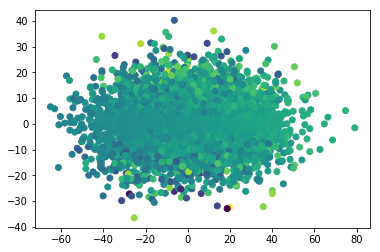

In [3]:
X,y = test_data_2()
plt.scatter(X[:,0],X[:,1],c=y)
#X.shape

In [12]:
def make_string(coeffs):
    s = ''
    for i,c in enumerate(coeffs):
        s+= 'x{}*{}+'.format(i,c)
    return s[:-1]

def make_data(coeffs,noise=0,n_samples=100,kind='reg'):
    formular = make_string(coeffs)
    np.random.seed(1)
    if kind == 'reg':
        data = gen_regression_symbolic(m=formular, n_samples=n_samples, noise=noise)
    if kind == 'clas':
        data = gen_classification_symbolic(m=formular, n_samples=n_samples, flip_y=noice) 
    X = data[:,:-1]
    y = data[:,-1]
    return X,y

def make_data_from_string(string,noise=0,n_samples=100,kind='reg'):
    if kind == 'reg':
        data = gen_regression_symbolic(m=string, n_samples=n_samples, noise=noise)
    if kind == 'clas':
        data = gen_classification_symbolic(m=string, n_samples=n_samples, flip_y=noice) 
    X = data[:,:-1]
    y = data[:,-1]
    return X,y

def scale_data(x,y):
    y=np.reshape(y, (-1,1)).astype(float)
    x = x.astype(float)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    #print(scaler_x.fit(x))
    xscale=scaler_x.transform(x)
    #print(scaler_y.fit(y))
    yscale=scaler_y.transform(y)
    return xscale, np.squeeze(yscale)


def train_and_evaluate_model(model,X,y,score_metric):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    score = score_metric(preds,y_test)
    return model, score, X_train
    
def calculate_kernel_shap_coeffs(model,X):
    model_f = lambda x: model.predict(x)
    reference_values = np.median(X,axis=0).reshape((1,X.shape[1])).astype(float)
    #reference_values = np.array([[1.9,1.9]])
    X = X.astype(float)
    explainer = shap.KernelExplainer(model_f,reference_values)
    shap_values = explainer.shap_values(X,l1_reg='aic',)
    #shap.summary_plot(shap_values,plot_type='bar')
    #plt.show()
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs, explainer, shap_values

def calculate_tree_shap_coeffs(model,X):
    X = X.astype(float)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    #shap.summary_plot(shap_values,plot_type='bar')
    #plt.show()
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs, explainer, shap_values

def calculate_linear_shap_coeffs(model,X):
    X = X.astype(float)
    explainer = shap.LinearExplainer(model,X,feature_dependence="independent")
    shap_values = explainer.shap_values(X)
    #shap.summary_plot(shap_values,plot_type='bar')
    #plt.show()
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs, explainer, shap_values

def calculate_deep_shap_coeffs(model,X):
    X = X.astype(float)
    background = X[np.random.choice(X.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model,background)
    shap_values = explainer.shap_values(X)
    #shap.summary_plot(shap_values,plot_type='bar')
    #plt.show()
    shap_coeffs = np.absolute(shap_values[0]).mean(axis=0)
    return shap_coeffs, explainer, shap_values[0]

def rel_values(array):
    return array/np.sum(np.absolute(array))

def distance(pred,true):
    p = np.absolute(pred)
    t = np.absolute(true)
    d = np.mean(np.abs(p-t)*t)
    return round(d,3)

def experiment(string=None,true_coeffs=[1,2],n_samples=100,noise=0,kind='reg',
               model=LinearRegression(),score_metric=mse,
               shap_calculator=calculate_tree_shap_coeffs,
              scaling = False, shift_data=[0,0]):
    print('Number of Samples:',n_samples)
    print('Degree of Noise: ',noise)
    
    if string:
        X,y = make_data_from_string(string,noise,n_samples,kind)
        print('Fomrular: ',string)
    else:  
        X,y = make_data(true_coeffs,noise,n_samples,kind)
        print('True Coefficients: ',true_coeffs)
    #X = X+shift_data
    #y = np.sum(X*true_coeffs,axis=1)
    if scaling == True:
        X,y = scale_data(X,y)
        

    ###############
    #X,y = test_data_2()
    
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.colorbar()
    plt.title('Data')
    plt.show()
    fitted_model, score, X_train = train_and_evaluate_model(model,X,y,score_metric)
    shap_coeffs, explainer, shap_values = shap_calculator(fitted_model,X)
    
    relative_shaps = rel_values(shap_coeffs)
    relative_coeffs = rel_values(true_coeffs)
    
    y_train_pred = fitted_model.predict(X_train)
    y_train_pred = np.squeeze(y_train_pred)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train_pred.tolist())
    plt.colorbar()
    plt.title('Prediction')
    plt.show()
    
    
    print('Relative Shaps:\t\t',relative_shaps)
    print('Relative Coefficients\t',relative_coeffs)
    d = distance(relative_coeffs,relative_shaps)
    print('Distance: ',d)
    print('Model Score: ',round(score,3))
    print('Singe example:')
    i = 0
    print('X and y:', X[i,:],y[i])
    print('Model Output:',fitted_model.predict(X[i,:].reshape(1, -1)))
    print('Shap Values:',shap_values[i,:])
    print('Shap output:',np.sum(shap_values[i,:])+np.mean(y))
    #print('Data: ',X[i,:]*true_coeffs,np.sum(X[i,:]*true_coeffs))
    display(shap.force_plot(explainer.expected_value, shap_values[i,:]))
    
    shap_interaction_values = explainer.shap_interaction_values(X)

    
    return shap_values, X, y, shap_interaction_values


def run(string=None,true_coeffs=[1,2],n_samples=100,noise=0,kind='reg',
               model=LinearRegression(),score_metric=mse,
               shap_calculator=calculate_tree_shap_coeffs,
              scaling = False, shift_data=[0,0]):

    
    if string:
        X,y = make_data_from_string(string,noise,n_samples,kind)
    else:  
        X,y = make_data(true_coeffs,noise,n_samples,kind)

    if scaling == True:
        X,y = scale_data(X,y)

    fitted_model, score, X_train = train_and_evaluate_model(model,X,y,score_metric)
    shap_coeffs, explainer, shap_values = shap_calculator(fitted_model,X)
    
    relative_shaps = rel_values(shap_coeffs)
    relative_coeffs = rel_values(true_coeffs)
    
    y_train_pred = fitted_model.predict(X_train)
    y_train_pred = np.squeeze(y_train_pred)
    
    return relative_shaps,relative_coeffs, score, noise
def create_keras_model(input_dim=2):
    model = Sequential()
    model.add(Dense(32, input_shape=(2,), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(8,  activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model
        


In [5]:
#model = xgboost.XGBRegressor()
shap_calculator = calculate_tree_shap_coeffs
scaling= False
string = None
result = defaultdict(list)
for i in np.arange(1,6):
    for j in np.arange(1,6):
        if i > j:
            continue
        else:
            true_coeffs = [i,j]
            np.random.seed(1)
            model = xgboost.XGBRegressor()
            relative_shaps, relative_coeffs, score, noise = run(string = string,
                                                               true_coeffs=true_coeffs,
                                                               n_samples=5000, 
                                                               model = model,
                                                               shap_calculator = shap_calculator, 
                                                               scaling=scaling)
            result['i'].append(i)
            result['j'].append(j)
            result['relative shap coeffs'].append(relative_shaps)
            result['relative true coeffs'].append(relative_coeffs)
            result['noise'].append(noise)
            result['model score'].append(score)
        
        
        

[10:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [6]:
result_df = pd.DataFrame.from_dict(result,orient='columns')
result_df[['relative shap coeff1','relative shap coeff2']] = pd.DataFrame(result_df['relative shap coeffs'].values.tolist())
result_df[['relative true coeff1','relative true coeff2']] = pd.DataFrame(result_df['relative true coeffs'].values.tolist())

result_df


,i,j,model score,noise,relative shap coeffs,relative true coeffs,relative shap coeff1,relative shap coeff2,relative true coeff1,relative true coeff2
0,1,1,0.160174,0,"[0.5041479, 0.49585208]","[0.5, 0.5]",0.504148,0.495852,0.500000,0.500000
1,1,2,0.325248,0,"[0.3342599, 0.6657401]","[0.3333333333333333, 0.6666666666666666]",0.334260,0.665740,0.333333,0.666667
2,1,3,0.531976,0,"[0.2488487, 0.75115126]","[0.25, 0.75]",0.248849,0.751151,0.250000,0.750000
3,1,4,0.707230,0,"[0.19829662, 0.80170333]","[0.2, 0.8]",0.198297,0.801703,0.200000,0.800000
4,1,5,0.932228,0,"[0.16393968, 0.83606035]","[0.16666666666666666, 0.8333333333333334]",0.163940,0.836060,0.166667,0.833333
5,2,2,0.636860,0,"[0.50401264, 0.49598733]","[0.5, 0.5]",0.504013,0.495987,0.500000,0.500000
6,2,3,0.989161,0,"[0.4036264, 0.5963736]","[0.4, 0.6]",0.403626,0.596374,0.400000,0.600000
7,2,4,1.311554,0,"[0.33451608, 0.66548395]","[0.3333333333333333, 0.6666666666666666]",0.334516,0.665484,0.333333,0.666667
8,2,5,1.663531,0,"[0.2853516, 0.71464837]","[0.2857142857142857, 0.7142857142857143]",0.285352,0.714648,0.285714,0.714286
9,3,3,1.488183,0,"[0.504137, 0.49586305]","[0.5, 0.5]",0.504137,0.495863,0.500000,0.500000


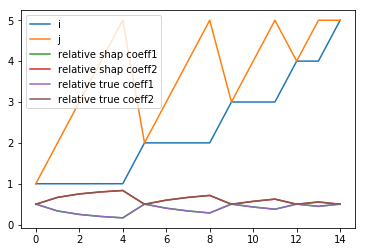

In [7]:
result_df[['i','j','relative shap coeff1','relative shap coeff2',
           'relative true coeff1','relative true coeff2']].plot()

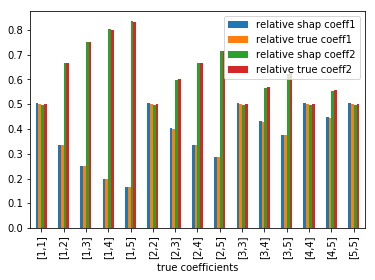

In [8]:
result_df[['relative shap coeff1','relative true coeff1',
           'relative shap coeff2','relative true coeff2']].plot.bar()
xtick = ['[{},{}]'.format(i,j) for i,j in zip(result_df['i'].values,result_df['j'].values)]
plt.xticks(result_df.index,xtick)
plt.xlabel('true coefficients')
plt.show()

Number of Samples: 5000
Degree of Noise:  0
Fomrular:  x1*1+x2*3+(x1*x2)


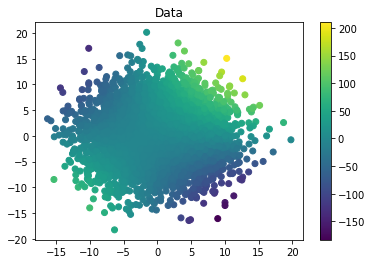

[10:55:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


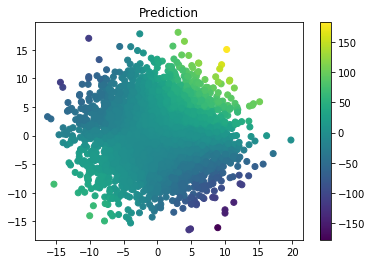

Relative Shaps:		 [0.38133946 0.6186605 ]
Relative Coefficients	 [0.25 0.75]
Distance:  0.066
Model Score:  22.841
Singe example:
X and y: [8.121726818316208 -4.623776418109702] -43.3026513728725
Model Output: [-43.483845]
Shap Values: [-10.938887 -32.58576 ]
Shap output: -43.2953195607491


In [13]:
np.random.seed(1)
model = xgboost.XGBRegressor()
shap_calculator = calculate_tree_shap_coeffs
#model = LinearRegression()
#shap_calculator = calculate_linear_shap_coeffs
#model = create_keras_model()
#shap_calculator = calculate_deep_shap_coeffs
#scaling=True
scaling=False
string = None
#string = 'x1**3+x2**2'
string = 'x1*1+x2*3+(x1*x2)'
#string = 'x1+(1/2)*x2'
true_coeffs = [1,3]
shap_values, X, y, shap_interaction_values = experiment(string = string,true_coeffs=true_coeffs,n_samples=5000, model = model , 
                               shap_calculator = shap_calculator, scaling=scaling)

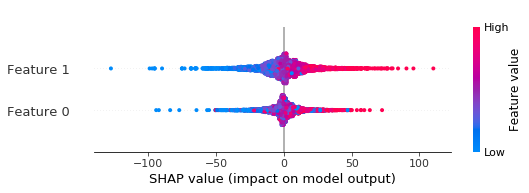

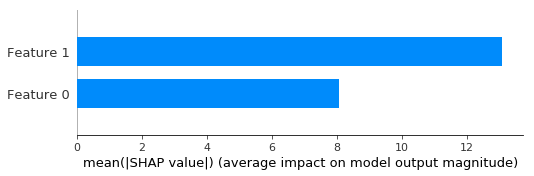

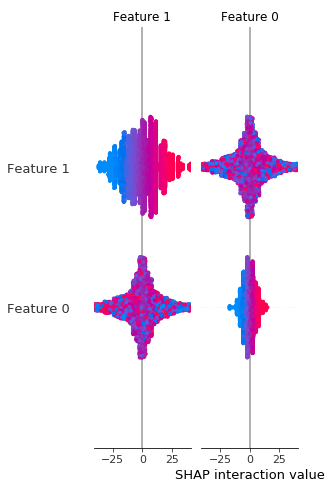

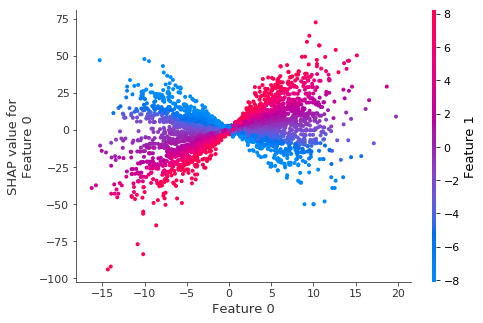

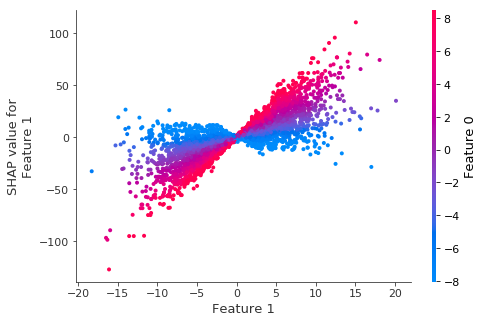

IndexError: index 2 is out of bounds for axis 1 with size 2

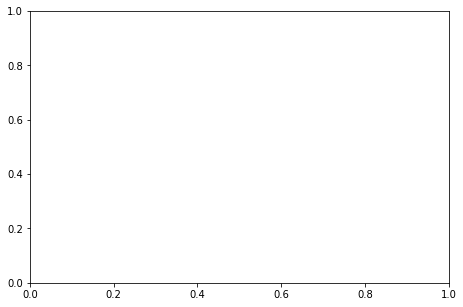

In [14]:
shap.summary_plot(shap_values, X, plot_type='dot')
shap.summary_plot(shap_values, X, plot_type='bar')
shap.summary_plot(shap_interaction_values, X, plot_type='dot')
for i in range(X.shape[0]):
    shap.dependence_plot(i,shap_values,X,)


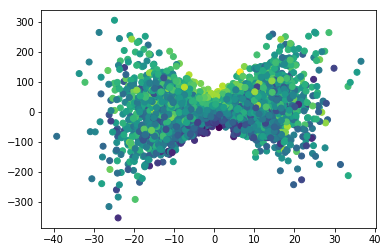

In [11]:

plt.scatter(X[:,1],y,c=X[:,0].astype(float))

In [5]:
p1 = 3
p2 = 2

In [12]:
l = []
for i in np.arange(-20,20):
    if i**p1+i**p2==0:
        continue
    a = i**p1 / (i**p1+i**p2 )
    b = i**p2 /( i**p1+i**p2 )
    l.append([a,b])
np.mean(l,axis=0)    

array([ 1.025, -0.025])

In [11]:
r = []
for x in X:
    x = np.absolute(x)
    a = x[0]**p1 / (x[0]**p1+x[1]**p2 )
    b = x[1]**p2 / (x[0]**p2+x[1]**p2 )
    r.append([a,b])
np.mean(r,axis=0)
    

array([0.6272805 , 0.49982415])